In [1]:
import fiona
import rasterio
from rasterio import transform, warp, mask
import pandas as pd
import geopandas as gp
import numpy as np
import math
import ipympl
import matplotlib.pyplot as plt
import matplotlib as mlp
import scipy.ndimage as ndi
import re

%matplotlib inline

In [2]:
import os

os.chdir("../../../core")
import GT_helper_functions as hf
import GT_load_data as data

base_dir = "../../Outcome Measurement Data/"

In [3]:
map_filename = "../../Covariates and Other Data/Geospatial Covariates/Malaria Atlas Project/map_pv_incidence_mean_1y_2015_00_00.tif"
map_raster = rasterio.open(map_filename)
map_raster.bounds

BoundingBox(left=-180.0, bottom=-89.99999999999281, right=179.99999999998562, top=90.0)

In [4]:
malap = map_raster.read(1)
malap.shape

(4320, 8640)

In [5]:
map_raster.transform

/home/guillermo/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


[-180.0, 0.041666666666665, 0.0, 90.0, 0.0, -0.041666666666665]

In [11]:
wpgt_file = "../../../DATOS/WorldPop/GTM_ppp_v2b_2015/GTM_ppp_v2b_2015.tif"
wpgt_r = rasterio.open(wpgt_file)
wpgt = wpgt_r.read(1)
wpgt_r.bounds

BoundingBox(left=-92.24071231229665, bottom=13.738426751815744, right=-88.22087311229664, top=17.81909685181575)

In [12]:
malap

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

In [13]:
map_reproj = np.empty(wpgt.shape, dtype='float32')

In [14]:
warp.reproject(source = malap, src_crs = map_raster.crs, src_transform = map_raster.affine,
               destination = map_reproj, dst_crs = wpgt_r.crs, dst_transform = wpgt_r.affine,
               resampling=warp.Resampling.nearest,
               num_threads=2)

In [15]:
map_reproj[map_reproj<0] = 0

In [16]:
wpgt[wpgt<0] = 0

In [17]:
map_reproj2 = map_reproj * wpgt

/home/guillermo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/guillermo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


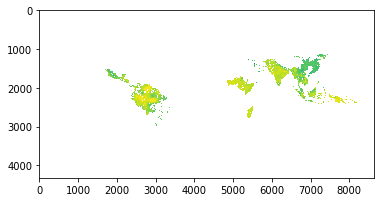

In [18]:
#plt.hist(map_reproj.flatten(), range=(0.01,0.04))
plt.imshow(np.log(malap))

In [19]:
munis = gp.read_file("../../Covariates and Other Data/GIS/GT-IGN-cartografia_basica-Division politica Administrativa (Municipios).geojson")
munis = munis[munis.COD_DEPT__.isna() == False]
deptos = gp.read_file("../../Covariates and Other Data/GIS/GT-IGN-cartografia_basica-Departamentos.geojson")
deptos = deptos[deptos.CODIGO != "2300"]

In [20]:
map_reproj2.shape, wpgt_r.shape

((4897, 4824), (4897, 4824))

In [21]:
def malapWp(muni):
    masked, affine = mask.mask(wpgt_r, [muni["geometry"].__geo_interface__], crop=False)
    valid_cells = masked.data>0
    # print(valid_cells.shape, map_reproj.shape)
    pop = np.sum(masked.data[valid_cells])
    ncases = np.sum(map_reproj2[valid_cells[0] & (map_reproj2 > 0)])
    return pop, ncases
munis_malap_masks = [malapWp(muni) for i, muni in munis.iterrows()]

In [22]:
sum([x[1] for x in munis_malap_masks])

16790.330533190496

In [23]:
munis["atlas_cases"] = [x[1] for x in munis_malap_masks]

In [24]:
munis.atlas_cases.sum()

16790.330533190496

(-92.44118572530701, -88.0205650721026, 13.535444278930049, 18.023456427768476)

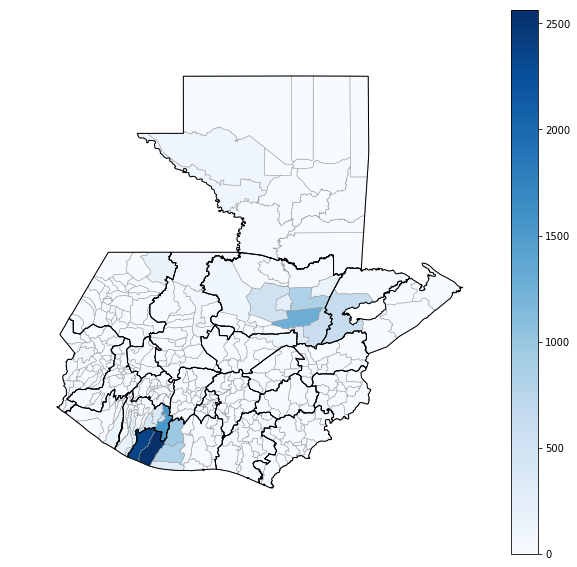

In [25]:
mlp.rcParams["figure.figsize"] = (10,10)
ax = munis.plot("atlas_cases", legend=True, cmap = "Blues", edgecolor="#999999", linewidth=0.5)
deptos.plot(edgecolor="black", linewidth=1, color="#55555500", ax = ax )
plt.axis("Off")

In [26]:
#ax = munis.plot("malap_sum", legend=True)
#deptos.plot(edgecolor="black", linewidth=2, color="#55555500", ax = ax )

deptos.assign(CODIGO = lambda x: np.floor(x.CODIGO.astype(int)/100))\
    .merge(munis.groupby("COD_DEPT__").malap_sum.sum().map(lambda x: x*100)\
           .reset_index().assign(COD_DEPT__ = lambda x: x.COD_DEPT__.astype(int)),
             left_on="CODIGO", right_on = "COD_DEPT__").plot("malap_sum", cmap = "Blues", edgecolor="black",
                                                            linewidth=1, legend=True)
plt.axis("off")

AttributeError: 'DataFrameGroupBy' object has no attribute 'malap_sum'